In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./ClosePrices.csv', index_col=0)

### First analysis the stock market

In [3]:
df.head()

,Name,Date,ClosePriceA,ClosePriceH,ExchangeRate,AdjustedPrice(H),A Growth,H Growth,PriceDiff,PriceDiffRate
1,民生银行,2010-01-04,7.93,8.87,0.88,7.8056,0.2528,1.7202,0.1244,0.015687
2,民生银行,2010-01-05,8.07,8.85,0.88,7.7880,1.7654,-0.2255,0.2820,0.034944
3,民生银行,2010-01-06,7.91,8.75,0.88,7.7000,-1.9827,-1.1299,0.2100,0.026549
4,民生银行,2010-01-07,7.70,8.68,0.88,7.6384,-2.6549,-0.8000,0.0616,0.008000
5,民生银行,2010-01-08,7.78,8.69,0.88,7.6472,1.0390,0.1152,0.1328,0.017069


In [4]:
df = df.dropna(axis=0)

### Build strategy

In [5]:
class Market:
    def __init__(self, A_price, H_price, adjustedA):
        self.A_price = A_price
        self.H_price = H_price
        self.adjustedA = adjustedA
        self.pricediff = A_price - adjustedA ### how much A share is higher than adjusted H share

In [6]:
class Trader:
    def __init__(self, A_hold, H_hold, fund):
        self.A_hold = A_hold
        self.H_hold = H_hold
        self.fund = fund
        self.buyDiff = None
        self.signal = 0 ### 1: buy H sell A; 0: no action; -1: buy A sell H
        self.state = 0 ### 1: 1H -1A 0: 0H 0A- 1: -1H 1A
        self.hold_time = 0
        
    def buyA(self, A_buy, market):
        self.A_hold += A_buy
        self.fund -= market.A_price*A_buy
        
    def buyH(self, H_buy, market):
        self.H_hold += H_buy
        self.fund -= market.adjustedA*H_buy
        
    def longH(self, market, diff):
        self.signal = 1
        self.buyA(-1, market)
        self.buyH(1, market)
        self.buyDiff = diff
        self.hold_time = 0
    
    def shortH(self, market, diff): ### buy 1A; sell 1H
        self.signal = -1
        self.buyA(1, market)
        self.buyH(-1, market)
        self.buyDiff = diff
        self.hold_time = 0

    def deal(self, market, mean, std):
        diff = market.pricediff
        if self.state != 0:
            self.hold_time += 1
        
        ### if hold too long, close a position
        if self.hold_time >= 30:
            if self.state == 1:
                self.shortH(market, diff)
                self.state = 0
                return
            elif self.state == -1:
                self.longH(market, diff)
                self.state = 0
        
        if self.state == 0: ### build position
            if diff>mean+0.75*std:
                self.longH(market, diff)
                self.state = 1
            elif diff<mean-0.75*std:
                self.shortH(market, diff)
                self.state = -1
            else:
                self.state = 0
        
        elif self.state == 1: ### close position
            if diff < self.buyDiff-1.5*std:
                self.shortH(market, diff)
                self.state = 0
            else:
                return
#                 self.state = 0
                
        elif self.state == -1: ### close position
            if diff > self.buyDiff+1.5*std:
                self.longH(market, diff)
                self.state = 0
            else:
                return
#                 self.state = 0

In [7]:
### some graphic info
fund_hist = []
A_hold_hist = []
H_hold_hist = []
state_hist = []

### a very simple test
### superparameters
INIT_A_SHARE = 0
INIT_H_SHARE = 0
FUND = 0
PERIOD = 50

trader = Trader(INIT_A_SHARE, INIT_H_SHARE, FUND)
for row in df.iterrows():
    idx = row[0]
    row = row[1]
    A_price = row['ClosePriceA']
    H_price = row['ClosePriceH']
    adjustedA = row['AdjustedPrice(H)']
    market = Market(A_price, H_price, adjustedA)
    period_df = df.loc[idx-PERIOD:idx-1]
    mean = np.mean(period_df['PriceDiff'])
    std = np.std(period_df['PriceDiff'])
    trader.deal(market, mean, std)
    
    ### add info to histogram
    fund_hist.append(trader.fund)
    A_hold_hist.append(trader.A_hold)
    H_hold_hist.append(trader.H_hold)
    state_hist.append(trader.state)

Text(0.5,1,'Trader Fund')

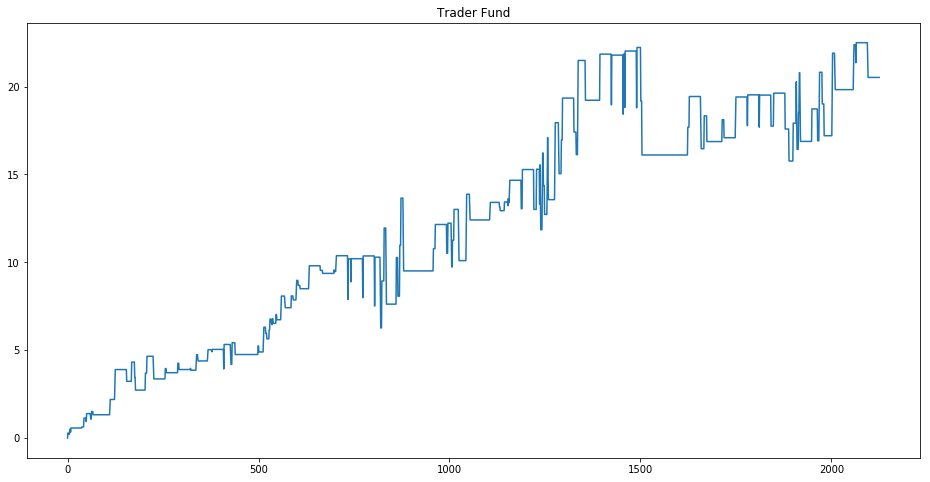

In [8]:
fig = plt.figure(figsize=(16,8))
plt.plot(fund_hist)
plt.title("Trader Fund")

Text(0.5,1,'A Share Hold')

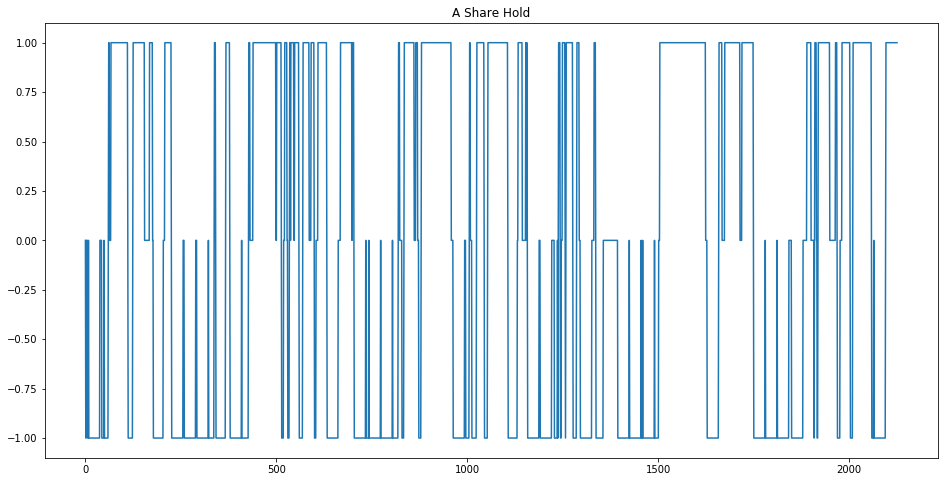

In [9]:
fig = plt.figure(figsize=(16,8))
plt.plot(A_hold_hist)
plt.title("A Share Hold")

Text(0.5,1,'H Share Hold')

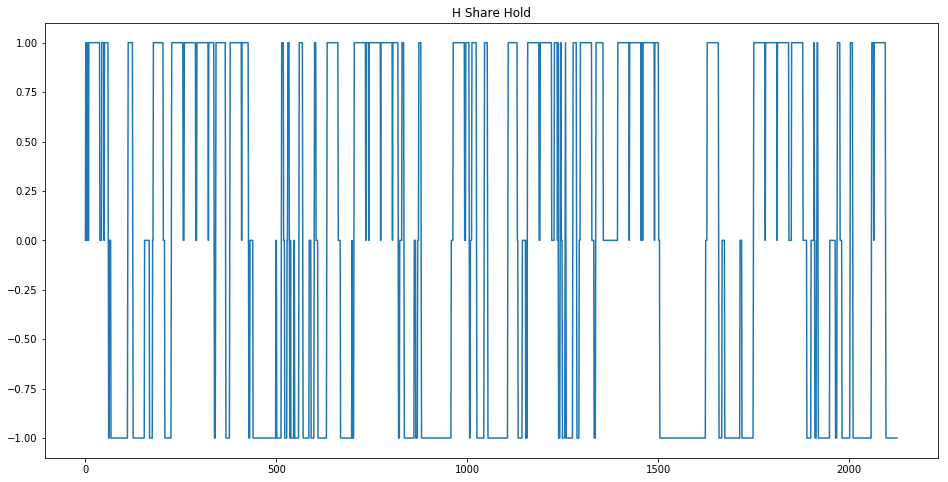

In [10]:
fig = plt.figure(figsize=(16,8))
plt.plot(H_hold_hist)
plt.title("H Share Hold")

In [11]:
signal_hist = []
fund_hist = []
A_hold_hist = []
H_hold_hist = []

In [12]:
trader.A_hold

1

In [13]:
trader.H_hold

-1

In [14]:
trader.fund

20.517699999999966

In [ ]:
import math

### Alternative strategy 1: hold A to the end

In [ ]:
A_return_hist = []

periods = int(df.shape[0]/30)
for i in range(periods):
    crt = i*30
    nxt = (i+1)*30
    try:
        last_price = df.loc[crt]['ClosePriceA']
        current_price = df.loc[nxt]['ClosePriceA']
        r = math.log(current_price/last_price)
        A_return_hist.append(r)
    except:
        continue

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(A_return_hist)

### Alternative strategy 2: hold H to the end

In [ ]:
H_return_hist = []

periods = int(df.shape[0]/30)
for i in range(periods):
    crt = i*30
    nxt = (i+1)*30
    try:
        last_price = df.loc[crt]['ClosePriceH']
        current_price = df.loc[nxt]['ClosePriceH']
        r = math.log(current_price/last_price)
        H_return_hist.append(r)
    except:
        continue

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(H_return_hist)

### Our strategy: arbitrage